1.仿照课件关于deepdream的程序，在data目录选择一张背景图片(zju1.jpg或zju2.jpg或zju3.jpg或zju4.jpg或者用代码下载一张网络图片保存在save/目录)， 选取一个ImageNet预训练网络，通过选择以及组合不同的特征层，训练出一张自己满意的deepdream图片。

In [1]:
import tensorflow as tf
import numpy as np
import IPython.display as display
import PIL.Image as PImg
from tensorflow.keras.preprocessing import image

In [2]:
def normalize_image(img):
    img = 255*(img+1.0)/2.0
    return tf.cast(img,tf.uint8)

def show_image(img):
    display.display(PImg.fromarray(np.array(img)))

def save_image(img,file_name):
    PImg.fromarray(np.array(img).save(file_name))

def read_image(file_name,max_dim=None):
    img = PImg.open(file_name)
    if max_dim:
        img.thumbnail((max_dim,max_dim))
    return np.array(img)

In [3]:
# # source image
# img_file = 'data/zju2.jpg'
# orig_img = read_image(img_file,500)
# show_image(orig_img)

# or: noise img or blank img
img_noise = np.random.uniform(-1,1,size=(300,300,3))+100
img_blank = np.zeros(shape=(300,300,3))+100
orig_img = img_noise

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

In [5]:
layer_names = 'conv2d_85'
layers = base_model.get_layer(layer_names).output
layers

<KerasTensor: shape=(None, None, None, 320) dtype=float32 (created by layer 'conv2d_85')>

In [6]:
dream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)
dream_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [7]:
def calc_loss_single(img,model):
    channel = 13
    img = tf.expand_dims(img,axis=0)
    layer_activations = model(img)
    act = layer_activations[:,:,:,channel]
    loss = tf.math.reduce_mean(act)
    return loss

def calc_loss_multi(img,model):
    channels = [13,19,39,139]
    img = tf.expand_dims(img,axis=0)
    layer_activations = model(img)

    losses = []
    for cn in channels:
        act = layer_activations[:,:,:,cn]
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

def render_deepdream(model,img,steps=100,step_size=0.01,verbose=1):
    for n in tf.range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            loss = calc_loss_multi(img,model)

        gradients = tape.gradient(loss,img)
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        img = img + gradients*step_size
        img = tf.clip_by_value(img,-1,-1)

        if (verbose==1):
            if ((n+1)%10==0):
                print('step {}/{}, loss {}'.format(n+1,steps,loss))
    return img

In [8]:
img = tf.keras.applications.inception_v3.preprocess_input(orig_img)
img = tf.convert_to_tensor(img)

start dreaming...
step 10/200, loss 0.0546683669090271
step 20/200, loss 0.0546683669090271
step 30/200, loss 0.0546683669090271
step 40/200, loss 0.0546683669090271
step 50/200, loss 0.0546683669090271
step 60/200, loss 0.0546683669090271
step 70/200, loss 0.0546683669090271
step 80/200, loss 0.0546683669090271
step 90/200, loss 0.0546683669090271
step 100/200, loss 0.0546683669090271
step 110/200, loss 0.0546683669090271
step 120/200, loss 0.0546683669090271
step 130/200, loss 0.0546683669090271
step 140/200, loss 0.0546683669090271
step 150/200, loss 0.0546683669090271
step 160/200, loss 0.0546683669090271
step 170/200, loss 0.0546683669090271
step 180/200, loss 0.0546683669090271
step 190/200, loss 0.0546683669090271
step 200/200, loss 0.0546683669090271
385.54263043403625
waking up...


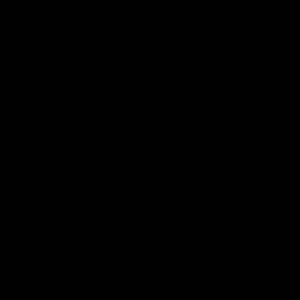

In [9]:
import time

start = time.time()
print('start dreaming...')

dream_img = render_deepdream(dream_model,img,steps=200,step_size=0.01)

end = time.time()
duration = end - start
print(duration)
print('waking up...')

dream_img = normalize_image(dream_img)
show_image(dream_img)